In [9]:
!pip install spacy==2.3.7 --user

  Using cached catalogue-1.0.0-py2.py3-none-any.whl (7.7 kB)
  Using cached thinc-7.4.5-cp38-cp38-win_amd64.whl (910 kB)


In [11]:
import numpy as np 
import pandas as pd

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import spacy
import en_core_sci_lg

from scipy.spatial.distance import jensenshannon

import joblib

from IPython.display import HTML, display

from ipywidgets import interact, Layout, HBox, VBox, Box
import ipywidgets as widgets
from IPython.display import clear_output

from tqdm import tqdm
from os.path import isfile

import json

import seaborn as sb
import matplotlib.pyplot as plt
plt.style.use("dark_background")

ModuleNotFoundError: No module named 'thinc.neural'

In [2]:
articlesPath = os.listdir("data")
len(articlesPath)


3280

In [50]:

df = pd.read_pickle('./processedDF.zip') 
len(df)


2825

In [11]:
df = pd.DataFrame(columns=['PMID', 'body', 'pubDate', 'title'])

s = pd.Series(df_processed['PMID']).unique()

for i in articlesPath:
    if (i.replace('.json', '').strip() in s) == False :
      with open(f'data/{i}') as f:
          article = json.loads(f.read())
      df = df.append(
          {'PMID': article['PMID'], 'body': article['body'], 'pubDate': article['pubDate'], 'title': article['title']}, ignore_index=True)


df.head()

,PMID,body
0,1,
1,10024467,
2,10075709,
3,10199401,
4,10329632,AbstractThe 3' box of the human class II snRN...


In [12]:
df.drop(df[df['body'].map(len) == 0].index, inplace=True) # delete where body is an empty array
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2825 entries, 4 to 3279
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   PMID    2825 non-null   object
 1   body    2825 non-null   object
dtypes: object(2)
memory usage: 66.2+ KB


In [51]:
import en_core_sci_lg
# medium model
nlp = en_core_sci_lg.load(disable=["tagger", "parser", "ner"])
nlp.max_length = 3000000

C:\Users\rouxa\anaconda3\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_sci_lg' (0.2.4) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.7). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [52]:
def spacy_tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not (word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)==1)]

In [61]:
# New stop words list 
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'org', 'https', 'et', 'al', 'author', 'figure', 'table',
    'rights', 'reserved', 'permission', 'use', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'elsevier', 'pmc', 'czi',
    '-PRON-', 'usually', 'pubmed', 'google', 'ii', 'article', 'free',
    r'\usepackage{amsbsy', r'\usepackage{amsfonts', r'\usepackage{mathrsfs', r'\usepackage{amssymb', r'\usepackage{wasysym',
    r'\setlength{\oddsidemargin}{-69pt',  r'\usepackage{upgreek', r'\documentclass[12pt]{minimal'
]

# Mark them as stop words
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

In [62]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, min_df=2)
data_vectorized = vectorizer.fit_transform(tqdm(df["processed_abstract"]))

100%|██████████| 2825/2825 [05:31<00:00,  8.52it/s]


In [63]:
data_vectorized.shape


(2825, 192584)

<AxesSubplot:ylabel='word'>

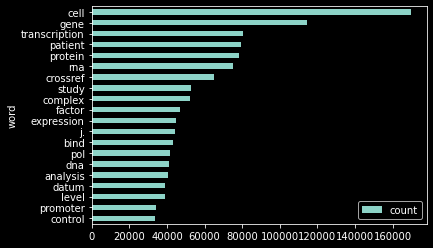

In [64]:
import numpy as np

# most frequent words


word_count = pd.DataFrame({'word': vectorizer.get_feature_names(), 'count': np.asarray(data_vectorized.sum(axis=0))[0]})

word_count.sort_values('count', ascending=False).set_index('word')[:20].sort_values('count', ascending=True).plot(kind='barh')

In [65]:
import joblib

joblib.dump(vectorizer, 'vectorizer.csv')
joblib.dump(data_vectorized, 'data_vectorized.csv')

['data_vectorized.csv']

In [66]:
lda = LatentDirichletAllocation(n_components=50, random_state=0)
lda.fit(data_vectorized)
joblib.dump(lda, 'lda.csv')

['lda.csv']

In [67]:
def print_top_words(model, vectorizer, n_top_words):
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        message = "\nTopic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [68]:
print_top_words(lda, vectorizer, n_top_words=25)


Topic #0: patient respiratory ards pressure ventilation lung acute care study distress syndrome peep med crossref high prone position volume mortality mechanical low crit oxygenation trial tidal

Topic #1: cell protein expression mm antibody control analysis datum assay perform buff level indicate min cancer sample experiment express crossref line blot wash follow incubate result

Topic #2: cell crossref lung acute cytokine response immune injury neutrophil inflammation pulmonary respiratory effect inflammatory med disease covid-19 treatment ards infection alveolar j. endothelial receptor increase

Topic #3: level cdk7 vitamin j. kinase sub1 m. cdk9 a. cell tax activity s. hcmv phosphorylation oga h. roscovitine increase serum r. t. c. k. antibody

Topic #4: group lung cell ecmo level treatment increase compare ali animal adenosine effect injury day rat hypoxia hypercapnia intestinal lps signal mouse expression ndr1 crossref significantly

Topic #5: ctd phosphorylation rna polymerase 

In [69]:
doc_topic_dist = pd.DataFrame(lda.transform(data_vectorized))
doc_topic_dist.to_csv('doc_topic_dist.csv', index=False)

In [70]:
doc_topic_dist.head()


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,...,0.070002,0.000230,0.063317,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230
1,0.000008,0.000008,0.000008,0.000008,0.000008,0.266501,0.000008,0.000008,0.000008,0.000008,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
2,0.000153,0.000153,0.000153,0.000153,0.000153,0.145516,0.000153,0.000153,0.000153,0.076142,...,0.000153,0.000153,0.000153,0.000153,0.148029,0.000153,0.000153,0.000153,0.000153,0.000153
3,0.000187,0.000187,0.000187,0.000187,0.000187,0.000187,0.000187,0.000187,0.000187,0.187136,...,0.012197,0.000187,0.000187,0.000187,0.000187,0.000187,0.000187,0.000187,0.000187,0.000187
4,0.000005,0.043620,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,...,0.053862,0.000005,0.000005,0.010618,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005


In [122]:
doc_topic_dist.shape

(2825, 50)

In [141]:
df2 = df

In [147]:
df = df2

In [143]:
df['pubDate'] = df['pubDate'][:4]

In [355]:
from scipy.spatial.distance import jensenshannon


def get_k_nearest_docs(doc_dist, k=5, lower=1950, upper=2022, only_covid19=False, get_dist=False):
    '''
    doc_dist: topic distribution (sums to 1) of one article

    Returns the index of the k nearest articles (as by Jensen–Shannon divergence in topic space). 
    '''

    relevant_time = df
    # .pubDate.between(int(lower), int(upper))
    # if only_covid19:
    #     temp = doc_topic_dist[relevant_time & is_covid19_article]

    # else:
    temp = doc_topic_dist
    # [relevant_time]

    # print('temp :', temp)
#     print('temp :', temp.shape)
    distances = pd.DataFrame(temp.apply(lambda x: jensenshannon(x, doc_dist), axis=1))

    column_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10','11', '12', '13', '14', '15', '16', '17', '18', '19',    '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',    '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',   '40', '41',      '42', '43', '44', '45', '46', '47', '48', '49']

    t = pd.DataFrame(columns= column_names)
    for i in range(distances.shape[0]):
        vals = {}
        for idx, y in enumerate(distances.iloc[i].values[0]):
            vals[f'{idx}']=y
        # print(vals)
        t= t.append(vals, ignore_index=True)
        # print(f'row {i}', t)

    k_nearest = t[t != 0].nsmallest(n=k, columns=column_names).index
    # test = pd.DataFrame(distances)
    # test = distances[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
    #      '11', '12', '13', '14', '15', '16', '17', '18', '19',    '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
    #       '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',   '40', '41',
    #        '42', '43', '44', '45', '46', '47', '48', '49']] = pd.DataFrame(distances, index=distances.index)
    # print(test)
# #     print('k : ', k)
    # print(distances[distances != 0].nsmallest(n=k, columns=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',    '20', '21', '22',
    #       '23', '24', '25', '26', '27', '28', '29',    '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',   '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']).index)
#     # print(distances[1904].nsmallest(n=k))
#     # k_nearest = distances[distances != 0].nsmallest(n=k).index
#     k_nearest = test[test != 0].nsmallest(n=k, columns=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',    '20', '21',
#                                           '22', '23', '24', '25', '26', '27', '28', '29',    '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',   '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']).index
    # k_nearest = t[t != 0].nsmallest(n=k).index
    # print('k nearest :', k_nearest)
    if get_dist:
        k_distances = t[t != 0].nsmallest(n=k, columns=column_names)
        return k_nearest, k_distances
    else:
        return k_nearest


In [384]:
df

,PMID,body,pubDate,title,language,processed_abstract
4,10329632,AbstractThe 3' box of the human class II snRN...,1999,Transcription of the human U2 snRNA genes cont...,en,abstractthe 3 box human class ii snrna gene re...
7,10421630,AbstractRNA polymerase II nascent transcripts...,1999,Transcription elongation factor hSPT5 stimulat...,en,abstractrna polymerase ii nascent transcript c...
8,10445882,AbstractLike its homologs in higher eukaryote...,1999,"Pac1p, an RNase III homolog, is required for f...",en,abstractlike homolog high eukaryote u2 snrna s...
9,10449415,"AbstractReplication protein A (RPA), the euka...",1999,The crystal structure of the complex of replic...,en,abstractreplication protein rpa eukaryote sing...
10,10454543,AbstractThe potent transactivator Tat recogni...,NaN,Tat-SF1 protein associates with RAP30 and huma...,en,abstractthe potent transactivator tat recogniz...
...,...,...,...,...,...,...
3267,9450929,AbstractWe report the identification of a tra...,NaN,"DSIF, a novel transcription elongation factor ...",en,abstractwe report identification transcription...
3269,9528797,AbstractThe multigene family encoding human U...,NaN,The microsatellite sequence (CT)n x (GA)n prom...,en,abstractthe multigene family encode human u2 s...
3271,9557709,AbstractInfection of human cells with adenovi...,NaN,A tandem array of minimal U1 small nuclear RNA...,en,abstractinfection human cell adenovirus seroty...
3274,9649443,AbstractYeast U2 snRNA is transcribed by RNA ...,NaN,Depletion of yeast RNase III blocks correct U2...,en,abstractyeast u2 snrna transcribe rna polymera...


In [390]:
def plot_article_dna(paper_id, width=20):
    t = df[df['PMID'] == paper_id].title.values[0]
    doc_topic_dist[df.PMID == paper_id].T.plot(kind='bar', legend=None, title=t, figsize=(width, 4))
    plt.xlabel('Topic')

def compare_dnas(paper_id, recommendation_id, width=20):
    iidx = df.index[df['PMID']  == recommendation_id]
    t = df.iloc[iidx].title.values[0]
    temp = doc_topic_dist.iloc[iidx]
    ymax = temp.max(axis=1).values[0]*1.25
    temp = pd.concat([temp, doc_topic_dist.iloc[iidx]])
    temp.T.plot(kind='bar', title=t, figsize=(width, 4), ylim= [0, ymax])
    plt.xlabel('Topic')
    plt.legend(['Selection', 'Recommendation'])

# compare_dnas('90b5ecf991032f3918ad43b252e17d1171b4ea63', 'a137eb51461b4a4ed3980aa5b9cb2f2c1cf0292a')

def dna_tabs(paper_ids):
    k = len(paper_ids)
    outs = [widgets.Output() for i in range(k)]

    tab = widgets.Tab(children = outs)
    tab_titles = ['Paper ' + str(i+1) for i in range(k)]
    for i, t in enumerate(tab_titles):
        tab.set_title(i, t)
    display(tab)

    for i, t in enumerate(tab_titles):
        with outs[i]:
            ax = plot_article_dna(paper_ids[i])
            plt.show(ax)

def compare_tabs(paper_id, recommendation_ids):
    k = len(recommendation_ids)
    print(k)
    outs = [widgets.Output() for i in range(k)]

    tab = widgets.Tab(children = outs)
    tab_titles = ['Paper ' + str(i+1) for i in range(k)]
    for i, t in enumerate(tab_titles):
        tab.set_title(i, t)
    display(tab)

    for i, t in enumerate(tab_titles):
        with outs[i]:
            ax = compare_dnas(paper_id, recommendation_ids[i])
            plt.show(ax)

In [351]:
get_k_nearest_docs(doc_topic_dist.iloc[np.flatnonzero(df.PMID == '32075058')])



distances : 2825
Int64Index([1674, 1804, 2742, 2369, 1747], dtype='int64')


Int64Index([1674, 1804, 2742, 2369, 1747], dtype='int64')

In [293]:
print(doc_topic_dist.iloc[np.flatnonzero(df.PMID == '32075058')])

            0         1         2         3         4         5         6   \
1634  0.000002  0.005207  0.005347  0.000002  0.000002  0.000002  0.000002   

            7         8         9   ...        40        41        42  \
1634  0.000002  0.000002  0.000162  ...  0.000841  0.000002  0.000002   

           43        44        45        46        47        48        49  
1634  0.04869  0.000002  0.006526  0.000002  0.031274  0.366487  0.160225  

[1 rows x 50 columns]


In [378]:
def recommendation(paper_id, k=5, lower=1950, upper=2022, only_covid19=False, plot_dna=False):
    '''
    Returns the title of the k papers that are closest (topic-wise) to the paper given by paper_id.
    '''
    
    print(df.title[df.PMID == paper_id].values[0])

    recommended, dist = get_k_nearest_docs(doc_topic_dist.iloc[np.flatnonzero(df.PMID == paper_id)], k, lower, upper, only_covid19, get_dist=True)
    recommended = df.iloc[recommended].copy()
    # recommended['similarity'] = 1 - dist 
    
    print(dist)
    print(dist.shape)

    h = '<br/>'.join(['<a href="data/' + l + '.json" target="_blank">'+ n + '</a>' for l, n in recommended[['PMID','title']].values])
    display(HTML(h))
    
    if plot_dna:
        compare_tabs(paper_id, recommended.PMID.values)

In [118]:
doc_topic_dist.shape

(2825, 50)

In [385]:
doc_topic_dist

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,...,0.070002,0.000230,0.063317,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230
1,0.000008,0.000008,0.000008,0.000008,0.000008,0.266501,0.000008,0.000008,0.000008,0.000008,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
2,0.000153,0.000153,0.000153,0.000153,0.000153,0.145516,0.000153,0.000153,0.000153,0.076142,...,0.000153,0.000153,0.000153,0.000153,0.148029,0.000153,0.000153,0.000153,0.000153,0.000153
3,0.000187,0.000187,0.000187,0.000187,0.000187,0.000187,0.000187,0.000187,0.000187,0.187136,...,0.012197,0.000187,0.000187,0.000187,0.000187,0.000187,0.000187,0.000187,0.000187,0.000187
4,0.000005,0.043620,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,...,0.053862,0.000005,0.000005,0.010618,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2820,0.000003,0.001079,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,...,0.000003,0.000003,0.000003,0.007451,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003
2821,0.000004,0.026295,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.011986,0.014889,0.018198,0.000004,0.000004,0.000004,0.000004,0.000004
2822,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,...,0.000005,0.000005,0.024721,0.025278,0.206268,0.000005,0.000005,0.000005,0.000005,0.000005
2823,0.000247,0.000247,0.000247,0.000247,0.000247,0.000247,0.000247,0.000247,0.000247,0.000247,...,0.000247,0.000247,0.000247,0.000247,0.106963,0.000247,0.000247,0.000247,0.000247,0.000247


In [391]:
recommendation('32075058', k=5, plot_dna=True)


P-TEFb as A Promising Therapeutic Target
             0         1         2         3         4         5         6  \
1674  0.000113  0.588671  0.588671  0.588671  0.588671  0.588671  0.588671   
1804  0.006045  0.588610  0.588610  0.588610  0.588610  0.588610  0.588610   
2742  0.007403  0.588668  0.588668  0.588668  0.588668  0.588668  0.588668   
2369  0.008912  0.588674  0.588674  0.588674  0.588674  0.588674  0.570673   
1747  0.009795  0.588684  0.588684  0.588684  0.588684  0.588684  0.588684   

             7         8         9  ...        40        41        42  \
1674  0.588671  0.588671  0.588671  ...  0.588671  0.588671  0.588671   
1804  0.588610  0.588610  0.588610  ...  0.588610  0.588610  0.588610   
2742  0.588668  0.588668  0.588668  ...  0.588668  0.588668  0.588668   
2369  0.588674  0.588674  0.588674  ...  0.588674  0.588674  0.588674   
1747  0.588684  0.588684  0.588684  ...  0.588684  0.588684  0.588684   

            43        44        45        46       

5


In [9]:

df.to_pickle('./findingProcessed.zip')

In [140]:
df

,PMID,body,pubDate,title,language,processed_abstract
4,10329632,AbstractThe 3' box of the human class II snRN...,1999,Transcription of the human U2 snRNA genes cont...,en,abstractthe 3 box human class ii snrna gene re...
7,10421630,AbstractRNA polymerase II nascent transcripts...,1999,Transcription elongation factor hSPT5 stimulat...,en,abstractrna polymerase ii nascent transcript c...
8,10445882,AbstractLike its homologs in higher eukaryote...,1999,"Pac1p, an RNase III homolog, is required for f...",en,abstractlike homolog high eukaryote u2 snrna s...
9,10449415,"AbstractReplication protein A (RPA), the euka...",1999,The crystal structure of the complex of replic...,en,abstractreplication protein rpa eukaryote sing...
10,10454543,AbstractThe potent transactivator Tat recogni...,1999,Tat-SF1 protein associates with RAP30 and huma...,en,abstractthe potent transactivator tat recogniz...
...,...,...,...,...,...,...
3267,9450929,AbstractWe report the identification of a tra...,1998,"DSIF, a novel transcription elongation factor ...",en,abstractwe report identification transcription...
3269,9528797,AbstractThe multigene family encoding human U...,1998,The microsatellite sequence (CT)n x (GA)n prom...,en,abstractthe multigene family encode human u2 s...
3271,9557709,AbstractInfection of human cells with adenovi...,1998,A tandem array of minimal U1 small nuclear RNA...,en,abstractinfection human cell adenovirus seroty...
3274,9649443,AbstractYeast U2 snRNA is transcribed by RNA ...,1998,Depletion of yeast RNase III blocks correct U2...,en,abstractyeast u2 snrna transcribe rna polymera...


AttributeError: 'range' object has no attribute 'tolist'